<a href="https://colab.research.google.com/github/wgrgwrght/Simple-Diffusion/blob/main/Simple_Diffusion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simple Diffusion Model

https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=a30368b2

https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=k13hj2mciCHA

https://arxiv.org/pdf/2006.11239.pdf

# Load MNist Data

In [137]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision

In [138]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', DEVICE)
device = DEVICE

Using device: cuda


In [139]:
train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.Lambda(lambda t: (t * 2) - 1)]))

test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               #torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.Lambda(lambda t: (t * 2) - 1)]))

all_data = torch.utils.data.ConcatDataset([train, test])

In [140]:
train_loader = DataLoader(all_data, batch_size=len(all_data), shuffle=True, drop_last=True)
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(f"Number of examples : {len(example_data)}")

Number of examples : 70000


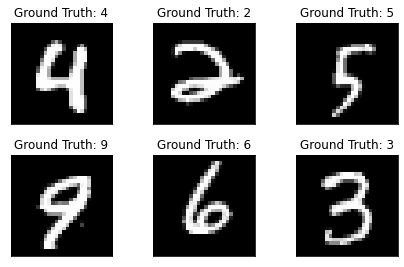

In [141]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(f"Ground Truth: {example_targets[i]}")
  plt.xticks([])
  plt.yticks([])

In [142]:
data = []
for i in range(len(example_data)):
  if int(example_targets[i]) == 0:
    data.append(example_data[i])

# BATCH_SIZE = 64
# dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Number of examples : {len(data)}")

Number of examples : 6903


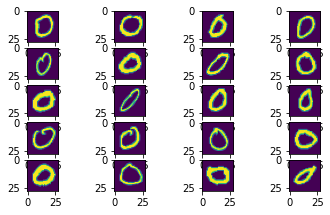

In [143]:
num_samples=20
cols=4
for i, img in enumerate(data):
    if i == num_samples:
        break
    plt.subplot(int(num_samples/cols + 1), cols, i + 1)
    plt.imshow(img[0])

# Noise Scheduler

In [144]:
# Define beta schedule
T = 200

# Variance schedule
betas = torch.linspace(0.0001, 0.02, T)

In [145]:
# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, axis=0)
alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)
posterior_variance = betas * (1. - alphas_bar_prev) / (1. - alphas_bar)

In [146]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_bar_t = get_index_from_list(sqrt_alphas_bar, t, x_0.shape)
    sqrt_one_minus_alphas_bar_t = get_index_from_list(
        sqrt_one_minus_alphas_bar, t, x_0.shape
    )

    mean = sqrt_alphas_bar_t.to(device) * x_0.to(device)
    variance = sqrt_one_minus_alphas_bar_t.to(device) * noise.to(device)

    return mean + variance, noise.to(device)

Example forward diffusion

In [147]:
"""
Image as input

Returns specified number of images showing forward noise diffusion
"""

def show_noisey(image, num_images):
  plt.figure(figsize=(15,15))
  stepsize = int(T/num_images)

  for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, int(num_images+1), int((idx/stepsize) + 1))
    image, noise = forward_diffusion_sample(image, t, device=device)
    plt.imshow(image.cpu())

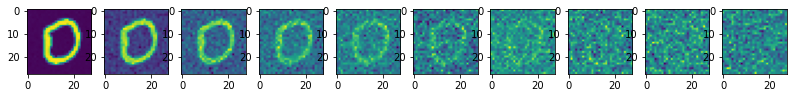

In [148]:
image = data[0][0]
num_images = 10

show_noisey(image, num_images)

# U-Net

In [149]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

In [150]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [151]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [152]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [153]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [154]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [155]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

# Loss function

In [156]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

# Sampling

In [157]:
def show_tensor_image(image):
    reverse_transforms = torchvision.transforms.Compose([
        #torchvision.transforms.Lambda(lambda t: (t + 1) / 2),
        #torchvision.transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        #torchvision.transforms.Lambda(lambda t: t * 255.),
        #torchvision.transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        torchvision.transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_bar_t = get_index_from_list(
        sqrt_one_minus_alphas_bar, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_bar_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = 28
    img = torch.randn((1, 1, img_size, img_size), device=device)

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images), int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()        

#Train Model

In [158]:
image_size = 28
channels = 1
BATCH_SIZE = 128

In [159]:
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [160]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Epoch 0 | step 000 Loss: 0.8807239532470703 


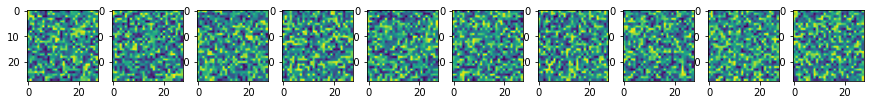

Epoch 1 | step 000 Loss: 0.4682614505290985 


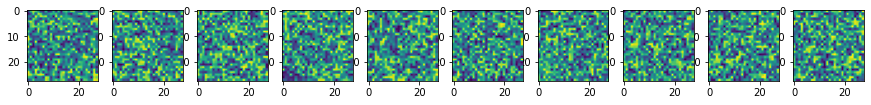

Epoch 2 | step 000 Loss: 0.30586978793144226 


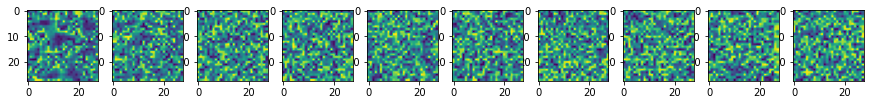

Epoch 3 | step 000 Loss: 0.25508129596710205 


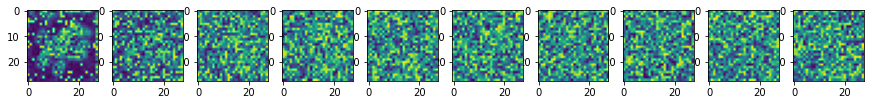

Epoch 4 | step 000 Loss: 0.2101772278547287 


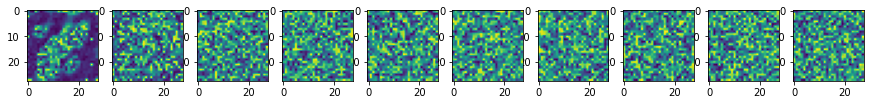

Epoch 5 | step 000 Loss: 0.1766321212053299 


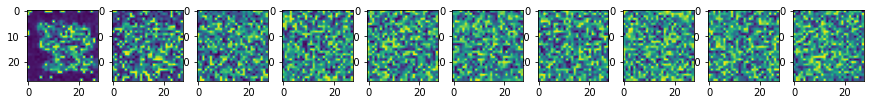

Epoch 6 | step 000 Loss: 0.1656447798013687 


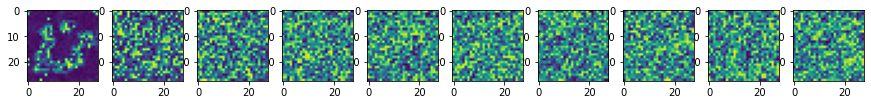

Epoch 7 | step 000 Loss: 0.17438872158527374 


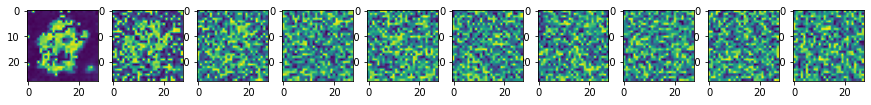

Epoch 8 | step 000 Loss: 0.16672760248184204 


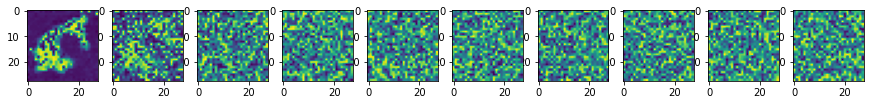

Epoch 9 | step 000 Loss: 0.1532377302646637 


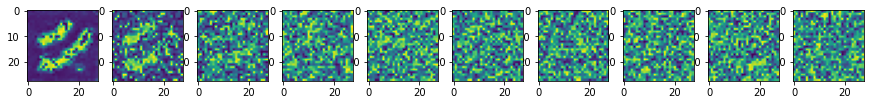

Epoch 10 | step 000 Loss: 0.13593898713588715 


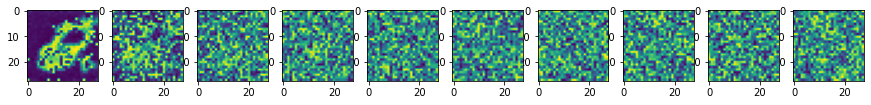

Epoch 11 | step 000 Loss: 0.14595980942249298 


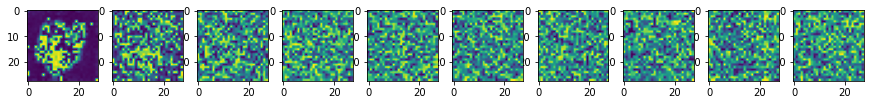

Epoch 12 | step 000 Loss: 0.13588500022888184 


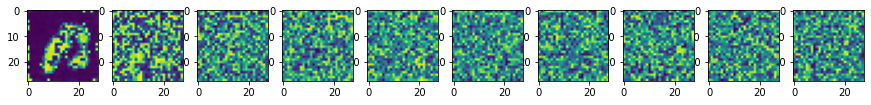

Epoch 13 | step 000 Loss: 0.1292857676744461 


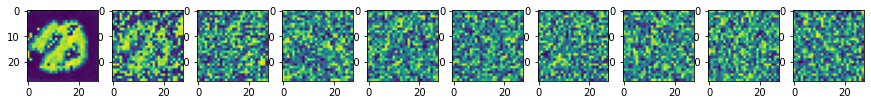

Epoch 14 | step 000 Loss: 0.13312743604183197 


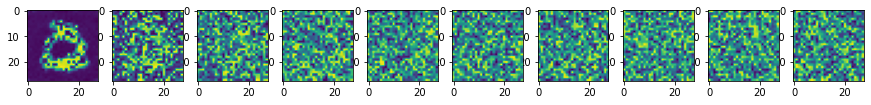

Epoch 15 | step 000 Loss: 0.13591323792934418 


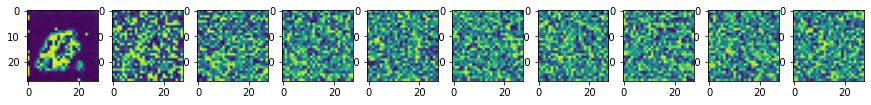

Epoch 16 | step 000 Loss: 0.13625821471214294 


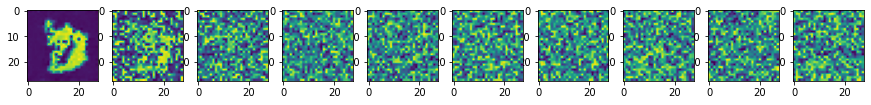

Epoch 17 | step 000 Loss: 0.11851458251476288 


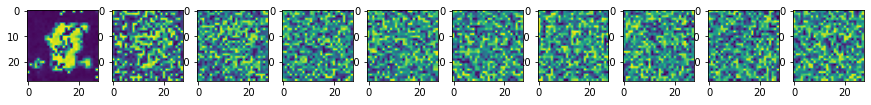

Epoch 18 | step 000 Loss: 0.12994596362113953 


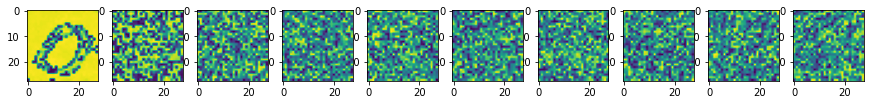

Epoch 19 | step 000 Loss: 0.1284496933221817 


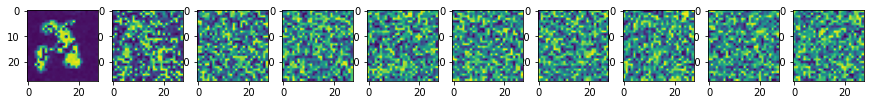

In [161]:
epochs = 20

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch.shape[0]
      batch = batch.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, T, (batch_size,), device=device).long()

      loss = get_loss(model, batch, t)

      loss.backward()
      optimizer.step()

      #if epoch % 20 ==0 and step == 0:
      if step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()


# Check Works

In [162]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [163]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_bar, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [164]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

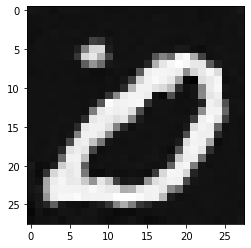

In [165]:
# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size), cmap="gray")